# Final Project - Bayesian model selection

This is the code underlying our final report, as can be found in the repository [here](https://github.com/dschuechter/physics760_schuechter_krause/tree/master/final_project/report). Note that not all plots may be exactly the same since they are generated each time the notebook runs. Of course we chose "pretty" plots in terms of the data for our report. Also note that each time the notebook runs figures are generated AND SAVED in the folder ``savepath``, if one does not change ``nametag`` the figures will be OVERWRITTEN.

In [1]:
import arviz as az
import numpy as np
import pymc3 as pm

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.special import betaln
from scipy.stats import beta
from scipy.stats import norm
from functions import beauty_plot
from functions import beauty_settings
from functions import beauty_settings_az

savepath = "../report/figs/"

# Coin Flip example
As an introductory example we study the example of a biased coin flip and sample from the posterior so as to find the true underlying modell via the Bayes factor.

In [2]:
np.random.seed(11)           # for reproducibility
a=0.25                       # biased coin
flips=np.random.rand(2**12)  # simulates 4096 coin flips
heads=flips<a    # boolean array, heads[i]=True if flip i is heads
np.sum(heads)

983

In [3]:
BF_smc = []
for i in range(0,20):#several monte carlo runs to estimate an error
    with pm.Model() as model1: #model of a fair coin
        theta = pm.Beta("$p(\\theta|M_1)$",50,50) #prior for the parameter theta
        yl = pm.Bernoulli("yl", theta, observed=heads[:50]) #likelihood given the measured data
        trace1 = pm.sample_smc(1000, parallel=False) #sample from posterior
    with pm.Model() as model2: #model of biased coin  
        theta = pm.Beta("$p(\\theta|M_2)$",5,13) #prior for the parameter theta
        yl = pm.Bernoulli("yl", theta, observed=heads[:50]) #likelihood given the measured data
        trace2 = pm.sample_smc(1000, parallel=False) #sample from posterior
    BF_smc.append(np.exp(trace2.report.log_marginal_likelihood - trace1.report.log_marginal_likelihood)[0])#bayes factor
    BF_smc.append(np.exp(trace2.report.log_marginal_likelihood - trace1.report.log_marginal_likelihood)[1])
print(BF_smc)


Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.587
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.579
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.574
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.572
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.551
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.592
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.598
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.577
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000


[8.882394021440492, 9.94114410708736, 10.090583256877261, 9.741481673532808, 9.838209231504228, 9.364046085147528, 10.118897852008208, 9.64413950125529, 10.109882839666293, 10.083206094855829, 9.928473671227405, 10.472175394755634, 9.081449574211632, 8.85990514663851, 9.643183910616939, 9.592180272189193, 9.95888172452391, 9.483747593444921, 9.222978858634312, 9.602259375311089, 8.7223745128426, 10.097196713728158, 10.072499067724424, 9.971461463431751, 9.717725637856478, 9.08967456491562, 9.520625023837207, 9.775322942274846, 9.42868710104848, 9.478499347728816, 9.738345624515736, 9.65688807530291, 9.418448842761567, 9.43036626068407, 10.284956824370113, 9.423774256801561, 9.495560718888806, 9.477720653219373, 9.565214001056129, 9.911663765466932]


In [4]:
print(np.mean(BF_smc))
print(np.std(BF_smc))

9.64840563958461
0.3901809506078996


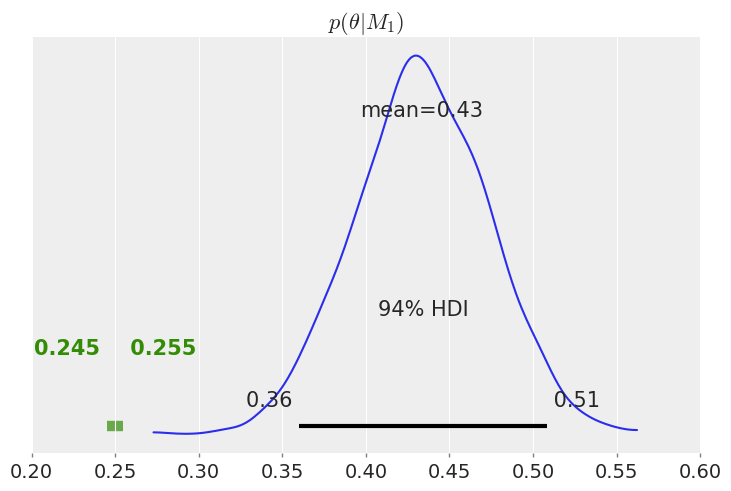

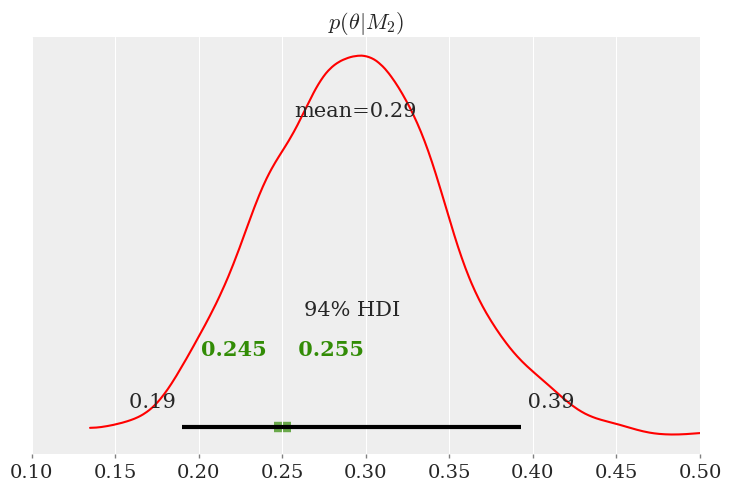

In [5]:
#plot what we just sampled.
with model1:
    az.style.use("arviz-darkgrid")
    az.plot_posterior(trace1,rope=[0.245,0.255])
    beauty_settings_az()
    plt.xlim(0.2,0.6)
    #plt.savefig(savepath+"coin_marp_m1.pdf")
    plt.show()
with model2:
    az.style.use("arviz-darkgrid")
    az.plot_posterior(trace2,rope=[0.245,0.255], color="red")
    beauty_settings_az()
    plt.xlim(0.1,0.5)
    #plt.savefig(savepath+"coin_marp_m2.pdf")
    plt.show()
az.style.use("default")


# Fitting a polynomial of unknown degree
After looking at the introductory example of the Coin Flip we now implement the simulation of data and fitting to the simulated data of several polynomials. Note that it is in fact easy to generate and fit higher order polynomials but we chose the simple one as to keep it easy to follow. 

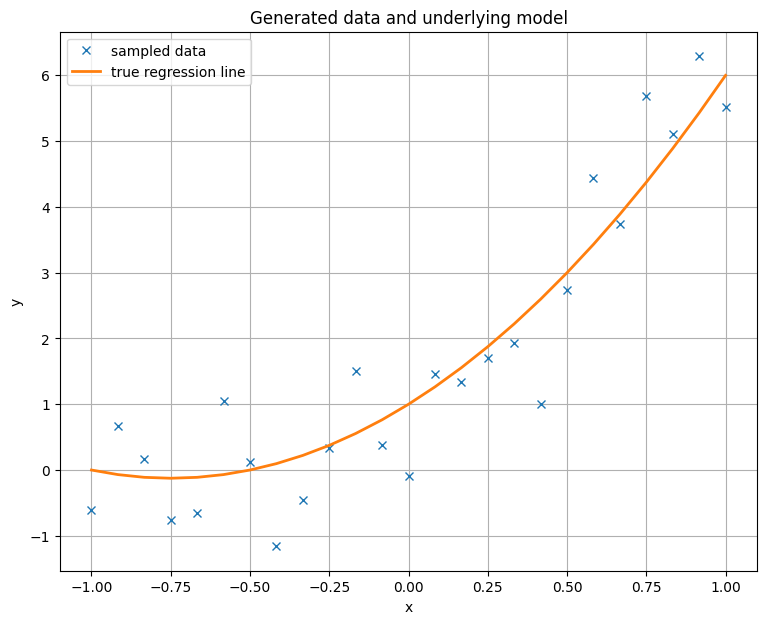

In [6]:
size = 25 #no of datapoints
true_intercept = 1 
true_a = 2
true_b = 3
#true_sq=2
sigma=.7 #noise
nametag="müll"
x = np.linspace(-1, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_b * x + true_a * x**2 
# add noise
y = true_regression_line + np.random.normal(scale=sigma, size=size)
data = dict(x=x, y=y)
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.grid()
plt.legend(loc=0);
plt.savefig(savepath+"data_regression_line"+nametag+".pdf", bbox_inches='tight')



In [7]:
def bayes_factor(trace1, trace2):
    return  np.exp(trace1.report.log_marginal_likelihood - trace2.report.log_marginal_likelihood)#bayes factor
def log_bayes_factor(trace1,trace2):
     return  (trace1.report.log_marginal_likelihood - trace2.report.log_marginal_likelihood)#bayes factor

In [8]:
sampleSize = 1000 #no. of samples that will be drawn from the posterior
prior_sigma = 2
bayes_factor_sq_lin = []
bayes_factor_cub_lin = []
bayes_factor_sq_cub = []
for i in range(0,5):#estimate an error of our estimates
    with pm.Model() as lin_model:  # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
        a = pm.Normal("a", 0, sigma=prior_sigma)

        mu = pm.Deterministic('mu', intercept + a * x)
        # Define likelihood
        likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
        # Inference!
        lin_trace =  pm.sample_smc(sampleSize, parallel=False) 

    with pm.Model() as const_model:  # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
        # Define likelihood
        mu = pm.Deterministic('mu', intercept+x*0)
        likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

        # Inference!
        const_trace =  pm.sample_smc(sampleSize, parallel=False) 

    with pm.Model() as sq_model:  # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        #sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
        intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
        a = pm.Normal("a", 0, sigma=prior_sigma)
        b = pm.Normal("b", 0, sigma=prior_sigma)

        # Define likelihood
        mu = pm.Deterministic('mu', intercept+x*b+a*x**2)
        likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

        # Inference!
        sq_trace =  pm.sample_smc(sampleSize, parallel=False) 

    with pm.Model() as cub_model:
        #define priors
        intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
        a = pm.Normal("a", 0, sigma=prior_sigma)
        b = pm.Normal("b", 0, sigma=prior_sigma)
        c = pm.Normal("c", 0, sigma=prior_sigma)
        #define likelihood
        mu = pm.Deterministic('mu', intercept+c*x+b*x**2+a*x**3)
        likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
        # Inference!
        cub_trace =  pm.sample_smc(sampleSize, parallel=False)
    bayes_factor_sq_lin.append(bayes_factor(sq_trace, lin_trace))
    bayes_factor_cub_lin.append(bayes_factor(cub_trace, lin_trace))
    bayes_factor_sq_cub.append(bayes_factor(sq_trace, cub_trace))
#note: sampled parameters are saved in a trace object, therefore we need only the traces afterwards

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.008
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.092
Stage:   3 Beta: 0.298
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.008
Stage:   1 Beta: 0.028
Stage:   2 Beta: 0.090
Stage:   3 Beta: 0.285
Stage:   4 Beta: 0.960
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.017
Stage:   1 Beta: 0.128
Stage:   2 Beta: 0.910
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.016
Stage:   1 Beta: 0.139
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.024
Stage:   2 Beta: 0.067
Stage:   3 Beta: 0.171
Stage:   4 Beta: 0.444
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.024
Stage:   2 Beta: 0.065
Stage:   3 Beta: 0.168
Stage:   4 Beta: 0.421
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.024
Stage:   2 Beta: 0.069
Stage:   3 Beta: 

In [9]:
print("Bayes factor Sq-Lin: "+str(np.mean(bayes_factor_sq_lin))+" +- " +str(np.std(bayes_factor_sq_lin))+ ', log:'+str(np.log(np.mean(bayes_factor_sq_lin)))+' +- '+ str(1/(np.mean(bayes_factor_sq_lin))*np.std(bayes_factor_sq_lin)))
print("Bayes factor Cub-Lin: "+str(np.mean(bayes_factor_cub_lin))+" +- "+ str(np.std(bayes_factor_cub_lin))+ ', log:'+str(np.log(np.mean(bayes_factor_cub_lin)))+' +- '+ str(1/(np.mean(bayes_factor_cub_lin))*np.std(bayes_factor_cub_lin)))
print("Bayes factor Sq-Cub: "+str(np.mean(bayes_factor_sq_cub))+" +- " +str(np.std(bayes_factor_sq_cub))+ ', log:'+str(np.log(np.mean(bayes_factor_sq_cub)))+' +- '+ str(1/(np.mean(bayes_factor_sq_cub))*np.std(bayes_factor_sq_cub)))

Bayes factor Sq-Lin: 2397211.678852572 +- 327164.404904556, log:14.689816819426722 +- 0.13647706115846792
Bayes factor Cub-Lin: 1026558.6750545806 +- 92973.52737770921, log:13.841722674113997 +- 0.09056815712240311
Bayes factor Sq-Cub: 2.3318852207836676 +- 0.18256985226660288, log:0.8466770480589592 +- 0.0782928124589457


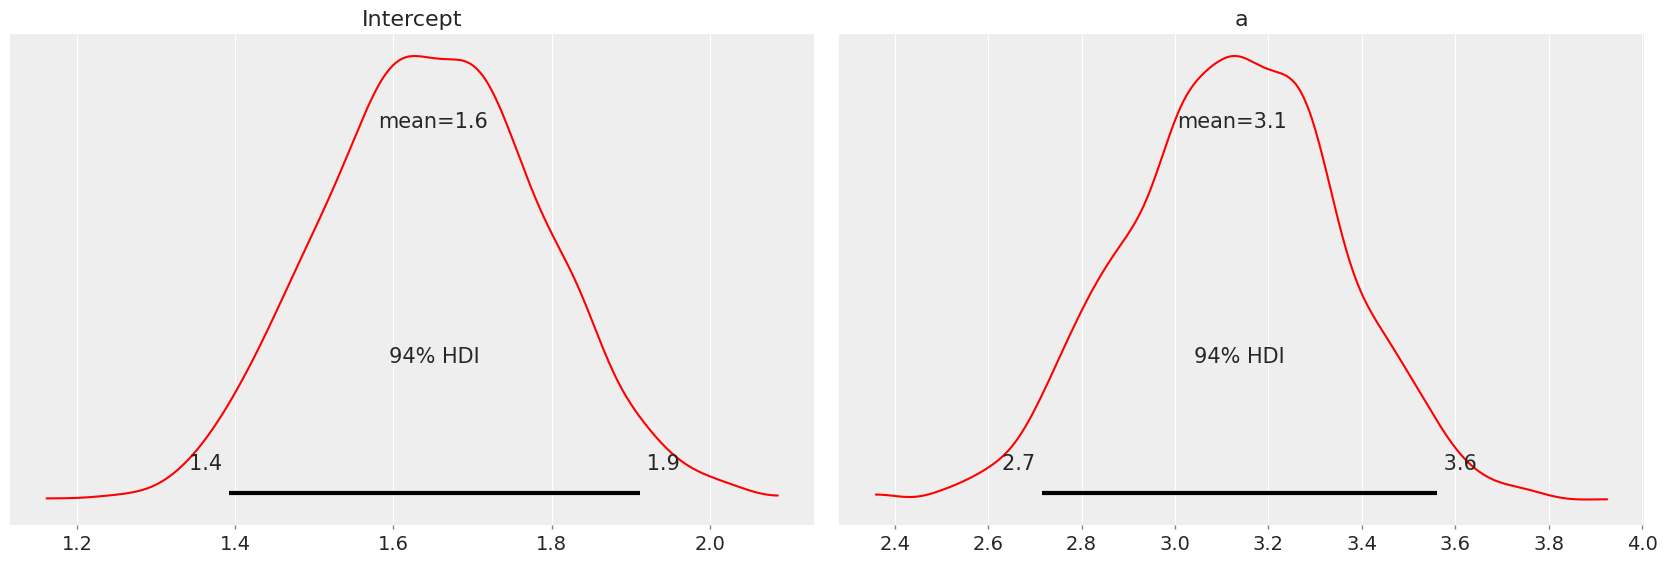

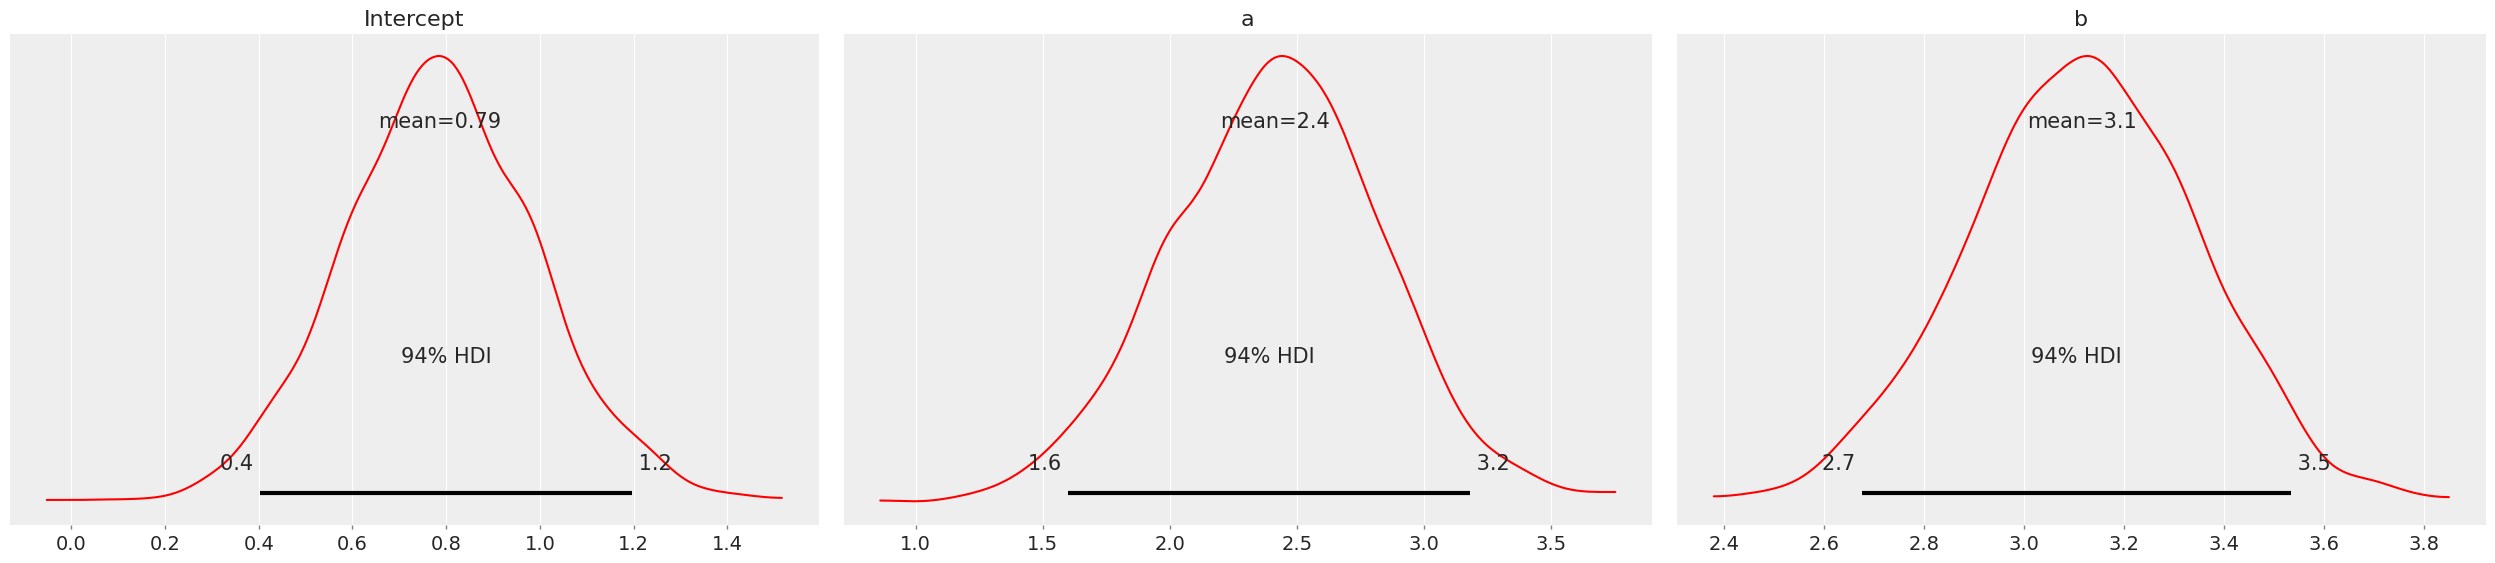

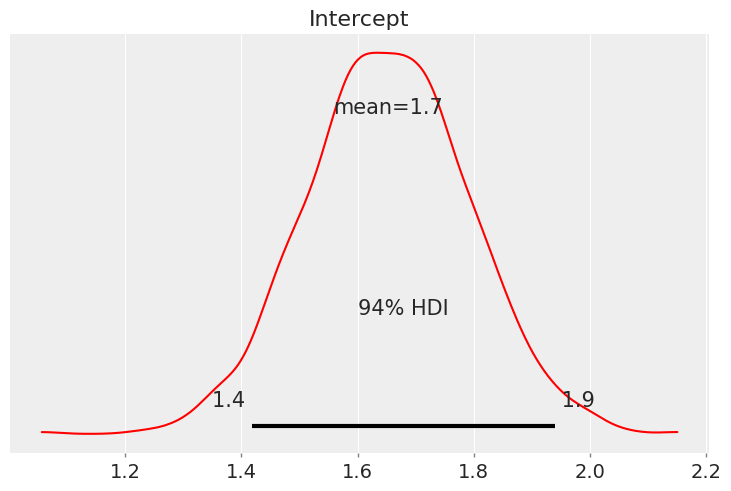

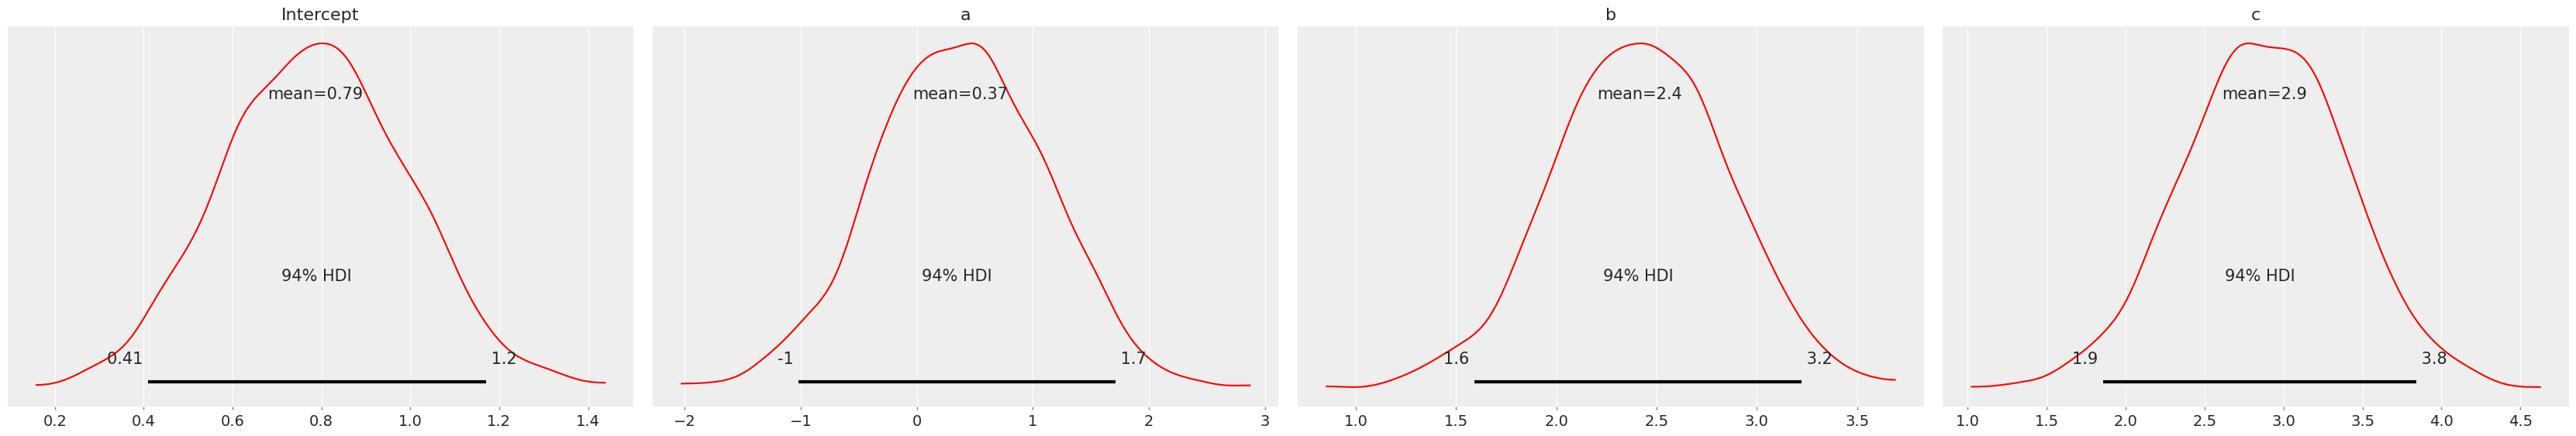

In [10]:
#plot the marginal posteriors for each sampled parameter, this is done by arviz 
az.style.use("arviz-darkgrid")
with lin_model:
    az.plot_posterior(lin_trace, var_names=['Intercept', 'a'], color="red")
    plt.savefig(savepath+"lin_model"+nametag+".pdf", bbox_inches='tight')


with sq_model:
    az.plot_posterior(sq_trace, var_names=['Intercept', 'a', 'b'], color="red")    
    plt.savefig(savepath+"sq_model"+nametag+".pdf", bbox_inches='tight')


with const_model:
    az.plot_posterior(const_trace, var_names=['Intercept'], color="red")
    plt.savefig(savepath+"const_model"+nametag+".pdf", bbox_inches='tight')

with cub_model:
    az.plot_posterior(cub_trace, var_names=['Intercept', 'a','b','c'], color="red")
    plt.savefig(savepath+"cub_model"+nametag+".pdf", bbox_inches='tight')


az.style.use("default")




/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


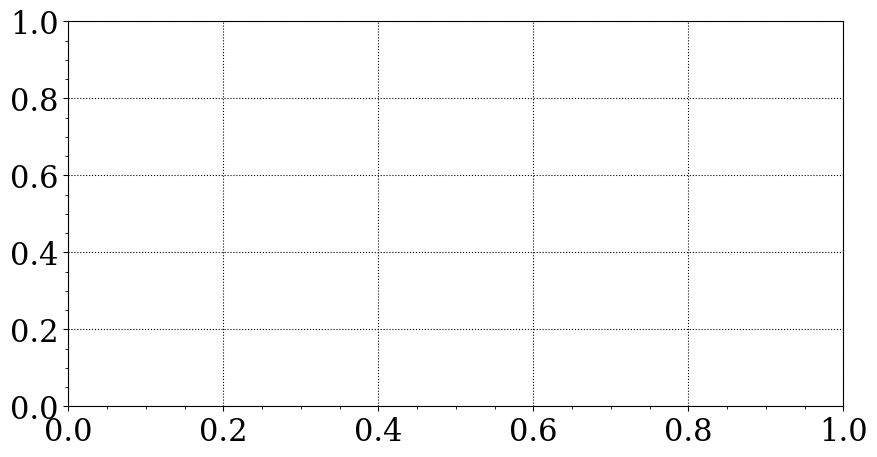

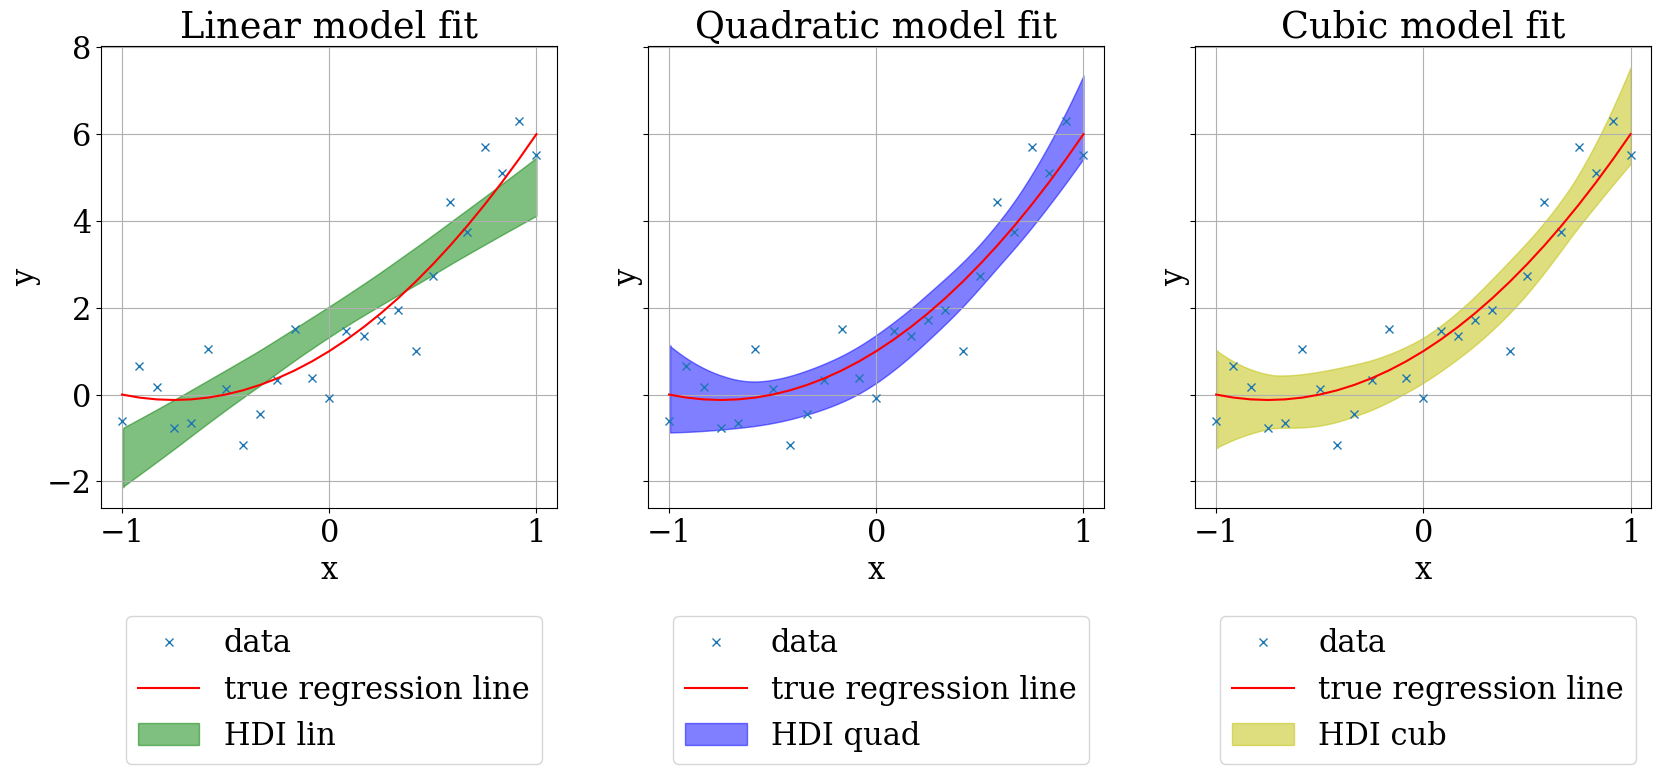

In [11]:
#now lets check what we just sampled
#first we plot our data again
#now plot the models and indicate the highest probability density region of 99%, this is taken care of by az.plot_hpd
# Creates two subplots and unpacks the output array immediately
beauty_plot()
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(20,6))
ax1.plot(x, y,"x",label="data")
ax1.plot(x,true_regression_line,label="true regression line",c="r")
az.plot_hdi(x, lin_trace['mu'], hdi_prob=.99, color='g',ax=ax1)
ax1.set_title('Linear model fit')

ax2.plot(x, y,"x",label="data")
ax2.plot(x,true_regression_line,label="true regression line",c="r")
az.plot_hdi(x, sq_trace['mu'], hdi_prob=.99, color='b',ax=ax2)

ax2.set_title('Quadratic model fit')
ax3.plot(x, y,"x",label="data")
ax3.plot(x,true_regression_line,label="true regression line",c="r")
az.plot_hdi(x, cub_trace['mu'], hdi_prob=.99, color='y',ax=ax3)
ax3.set_title('Cubic model fit')
ax1.grid()
ax1.legend()
# where some data has already been plotted to ax
handles, labels = ax1.get_legend_handles_labels()
# manually define a new patch 
patch = mpatches.Patch(color='g',alpha=0.5,label='HDI lin')
# handles is a list, so append manual patch
handles.append(patch) 
# plot the legend
ax1.legend(handles=handles,bbox_to_anchor=(1,-0.2), ncol=1)
ax2.grid()
ax2.legend()
# where some data has already been plotted to ax
handles, labels = ax2.get_legend_handles_labels()
# manually define a new patch 
patch = mpatches.Patch(color='b',alpha=0.5,label='HDI quad')
# handles is a list, so append manual patch
handles.append(patch) 
# plot the legend
ax2.legend(handles=handles,bbox_to_anchor=(1,-0.2), ncol=1)
#ax3.legend(loc="")
ax3.grid()
# where some data has already been plotted to ax
handles, labels = ax3.get_legend_handles_labels()
# manually define a new patch 
patch = mpatches.Patch(color='y',alpha=0.5,label='HDI cub')
# handles is a list, so append manual patch
handles.append(patch) 
# plot the legend
ax3.legend(handles=handles,bbox_to_anchor=(1,-0.2), ncol=1)


ax1.set_xlabel("x")
ax1.set_ylabel("y");
ax2.set_xlabel("x")
ax2.set_ylabel("y");
ax3.set_xlabel("x")
ax3.set_ylabel("y");
plt.show()
f.savefig(savepath+"HDI"+nametag+".pdf", bbox_inches='tight')




## Savage Dickey Density Ratio (SDDR)

To cross-check our findings of bayes factors via SMC we implement a way of computing the bayes factor which only depends on one marginal posterior and prior, the SDDR.

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.026
Stage:   2 Beta: 0.087
Stage:   3 Beta: 0.290
Stage:   4 Beta: 0.975
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.027
Stage:   2 Beta: 0.085
Stage:   3 Beta: 0.277
Stage:   4 Beta: 0.918
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.017
Stage:   1 Beta: 0.149
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.016
Stage:   1 Beta: 0.136
Stage:   2 Beta: 0.944
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.025
Stage:   2 Beta: 0.065
Stage:   3 Beta: 0.166
Stage:   4 Beta: 0.412
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.024
Stage:   2 Beta: 0.065
Stage:   3 Beta: 0.164
Stage:   4 Beta: 0.411
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.024
Stage:   2 Beta: 

Integral:  1.0
SDDR: loooog -1.8029965542376452


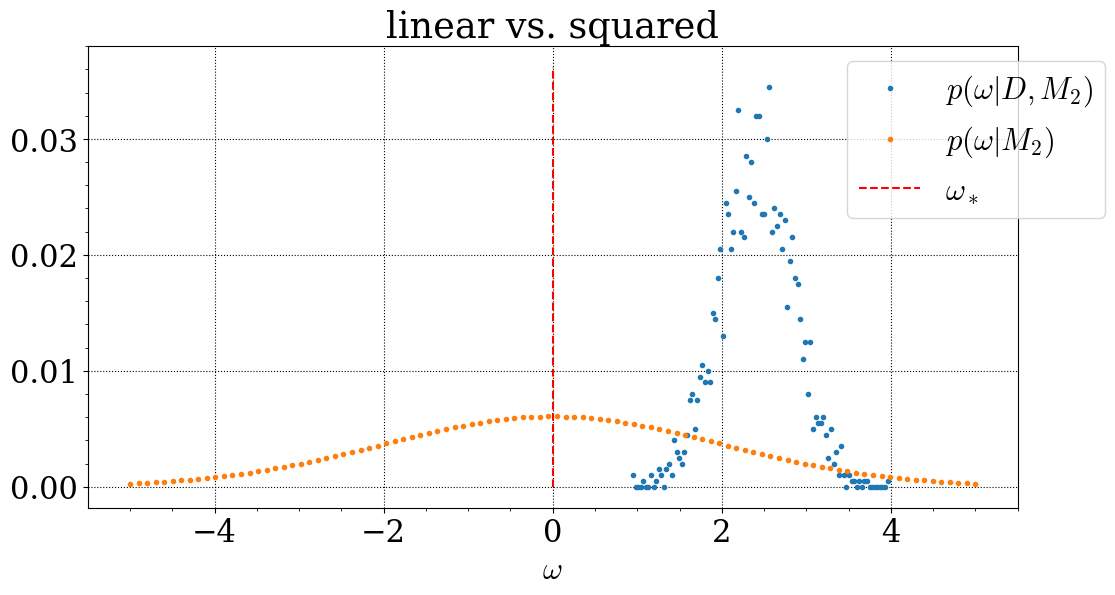

Integral:  0.9999999999999998
SDDR: loooog 0.9446373340734139


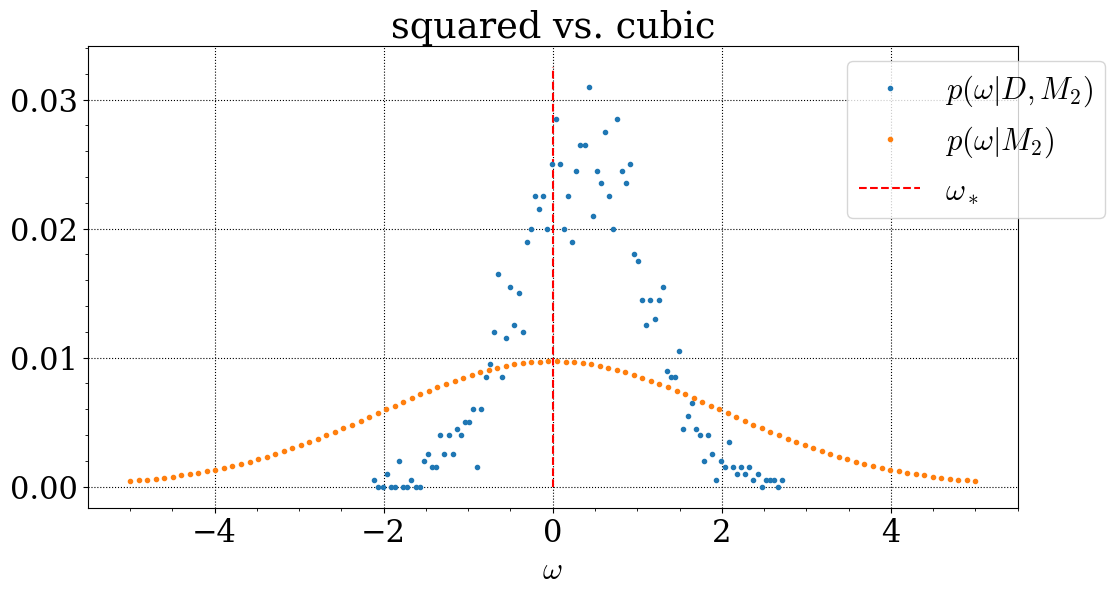

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.027
Stage:   2 Beta: 0.083
Stage:   3 Beta: 0.258
Stage:   4 Beta: 0.860
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.008
Stage:   1 Beta: 0.028
Stage:   2 Beta: 0.088
Stage:   3 Beta: 0.276
Stage:   4 Beta: 0.956
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.016
Stage:   1 Beta: 0.130
Stage:   2 Beta: 0.926
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.017
Stage:   1 Beta: 0.135
Stage:   2 Beta: 0.893
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.023
Stage:   2 Beta: 0.065
Stage:   3 Beta: 0.165
Stage:   4 Beta: 0.426
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.025
Stage:   2 Beta: 0.066
Stage:   3 Beta: 0.171
Stage:   4 Beta: 0.440
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.006
Stage:   1 Beta: 

Integral:  0.9999999999999999
SDDR: loooog -2.464820279345886


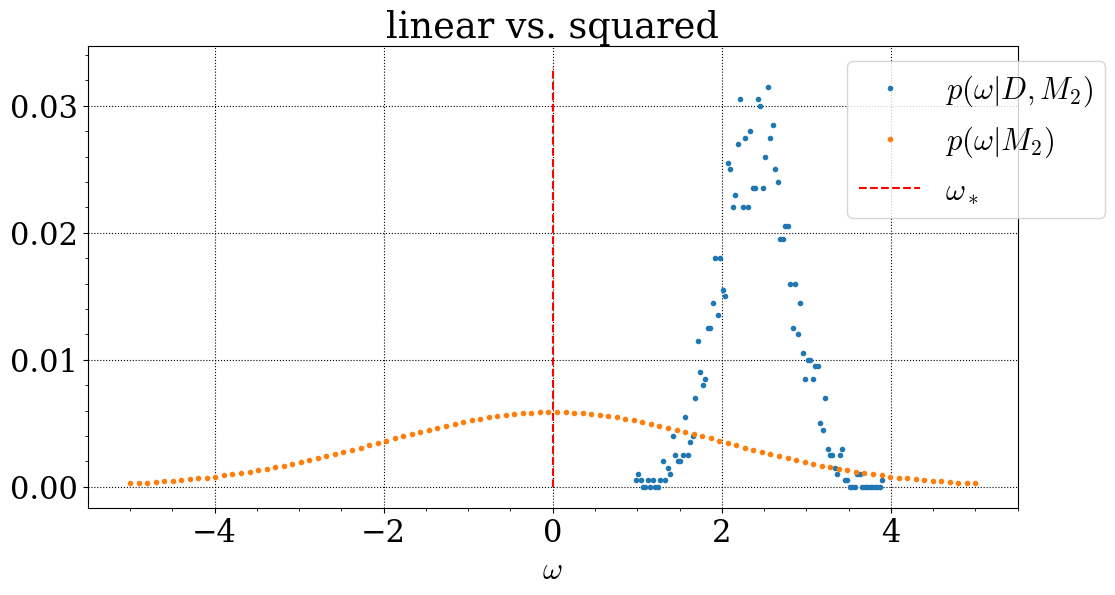

Integral:  0.9999999999999999
SDDR: loooog 0.8087605285039946


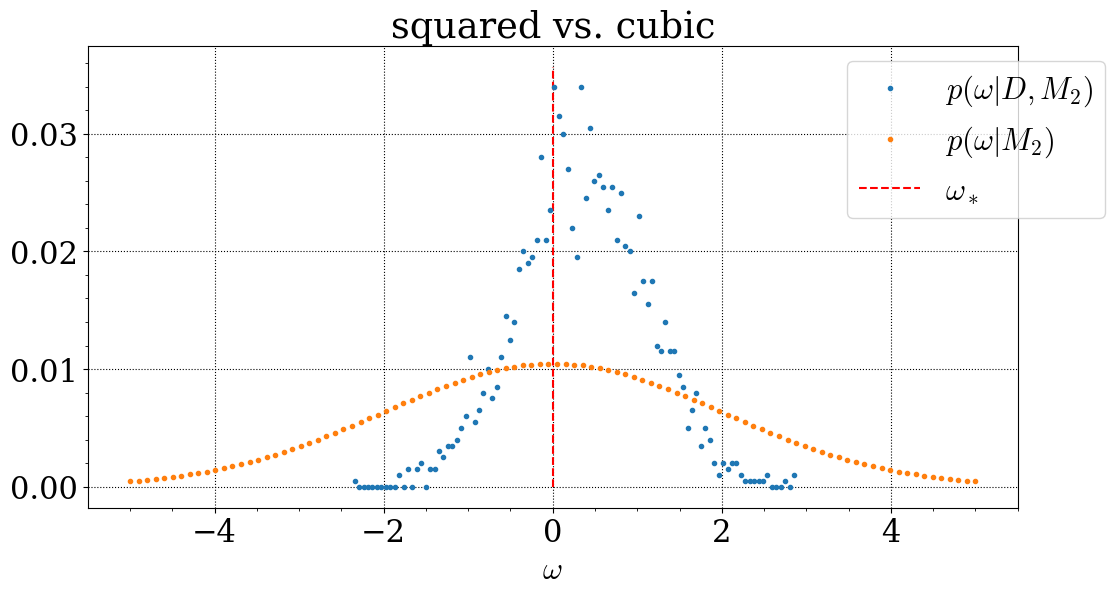

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.028
Stage:   2 Beta: 0.088
Stage:   3 Beta: 0.280
Stage:   4 Beta: 0.913
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.008
Stage:   1 Beta: 0.027
Stage:   2 Beta: 0.083
Stage:   3 Beta: 0.274
Stage:   4 Beta: 0.889
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.018
Stage:   1 Beta: 0.133
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.018
Stage:   1 Beta: 0.159
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.023
Stage:   2 Beta: 0.064
Stage:   3 Beta: 0.164
Stage:   4 Beta: 0.420
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.025
Stage:   2 Beta: 0.066
Stage:   3 Beta: 0.168
Stage:   4 Beta: 0.420
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.024
Stage:   2 Beta: 0.066
Stage:   3 Beta: 

Integral:  0.9999999999999998
SDDR: loooog -1.6331451987295857


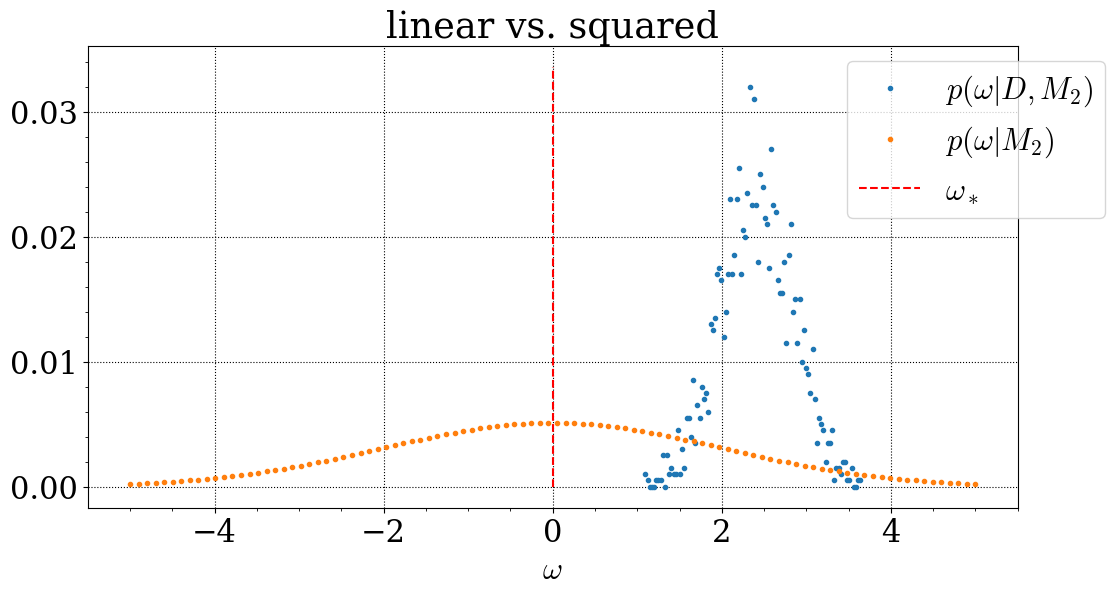

Integral:  1.0
SDDR: loooog 0.9533384013515562


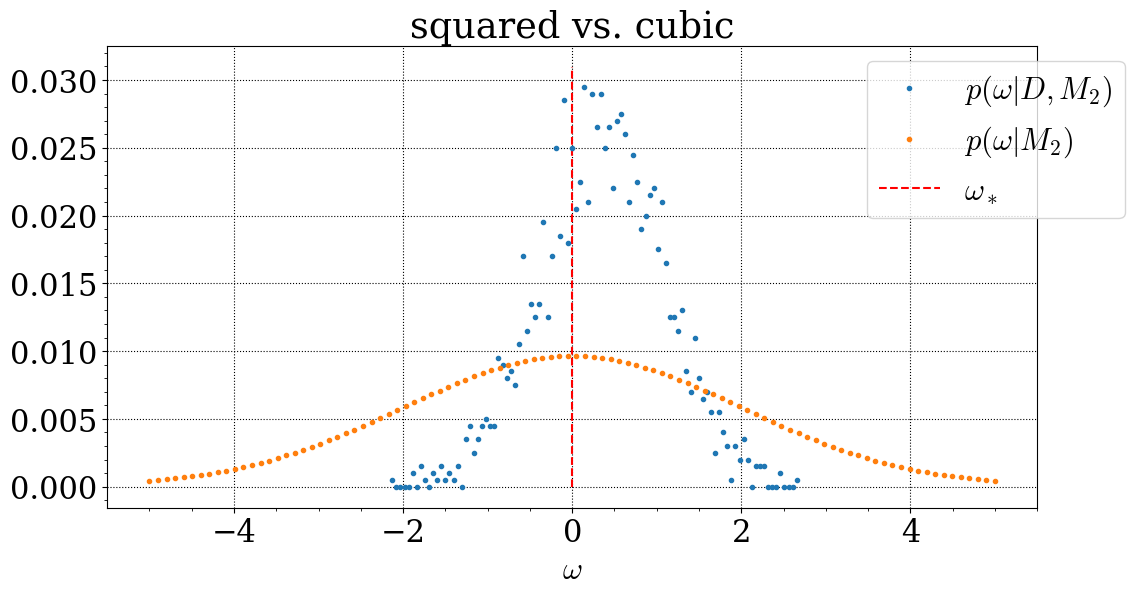

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.008
Stage:   1 Beta: 0.028
Stage:   2 Beta: 0.090
Stage:   3 Beta: 0.298
Stage:   4 Beta: 0.961
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.028
Stage:   2 Beta: 0.089
Stage:   3 Beta: 0.287
Stage:   4 Beta: 0.955
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.017
Stage:   1 Beta: 0.140
Stage:   2 Beta: 0.972
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.016
Stage:   1 Beta: 0.136
Stage:   2 Beta: 0.963
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.024
Stage:   2 Beta: 0.062
Stage:   3 Beta: 0.163
Stage:   4 Beta: 0.416
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.023
Stage:   2 Beta: 0.062
Stage:   3 Beta: 0.159
Stage:   4 Beta: 0.396
Stage:   5 Beta: 0.997
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 

Integral:  1.0
SDDR: loooog -2.4620553891237544


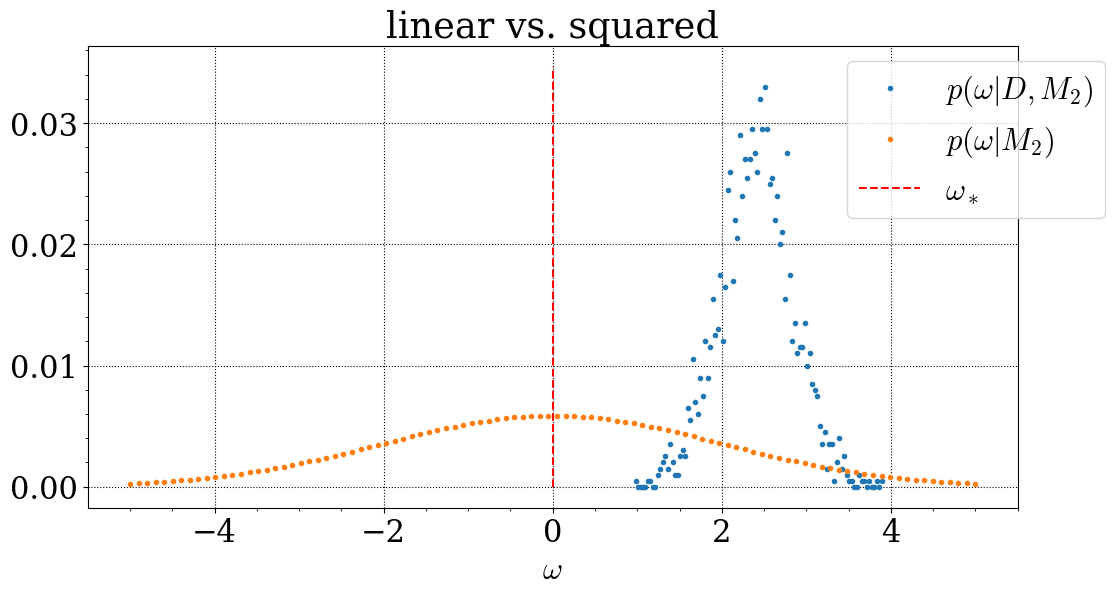

Integral:  0.9999999999999999
SDDR: loooog 0.6961825190636792


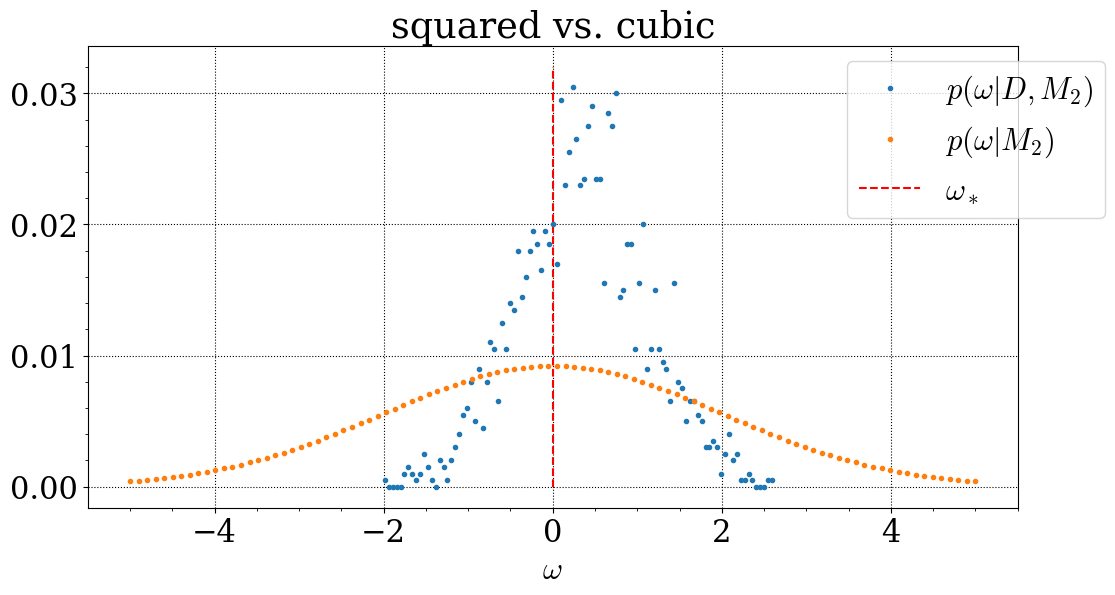

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.028
Stage:   2 Beta: 0.091
Stage:   3 Beta: 0.291
Stage:   4 Beta: 0.950
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.008
Stage:   1 Beta: 0.027
Stage:   2 Beta: 0.087
Stage:   3 Beta: 0.289
Stage:   4 Beta: 0.997
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.016
Stage:   1 Beta: 0.132
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.017
Stage:   1 Beta: 0.146
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.024
Stage:   2 Beta: 0.062
Stage:   3 Beta: 0.159
Stage:   4 Beta: 0.397
Stage:   5 Beta: 0.992
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.024
Stage:   2 Beta: 0.066
Stage:   3 Beta: 0.169
Stage:   4 Beta: 0.412
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.023
Stage:   2 Beta: 

Integral:  0.9999999999999999
SDDR: loooog -2.392834928274332


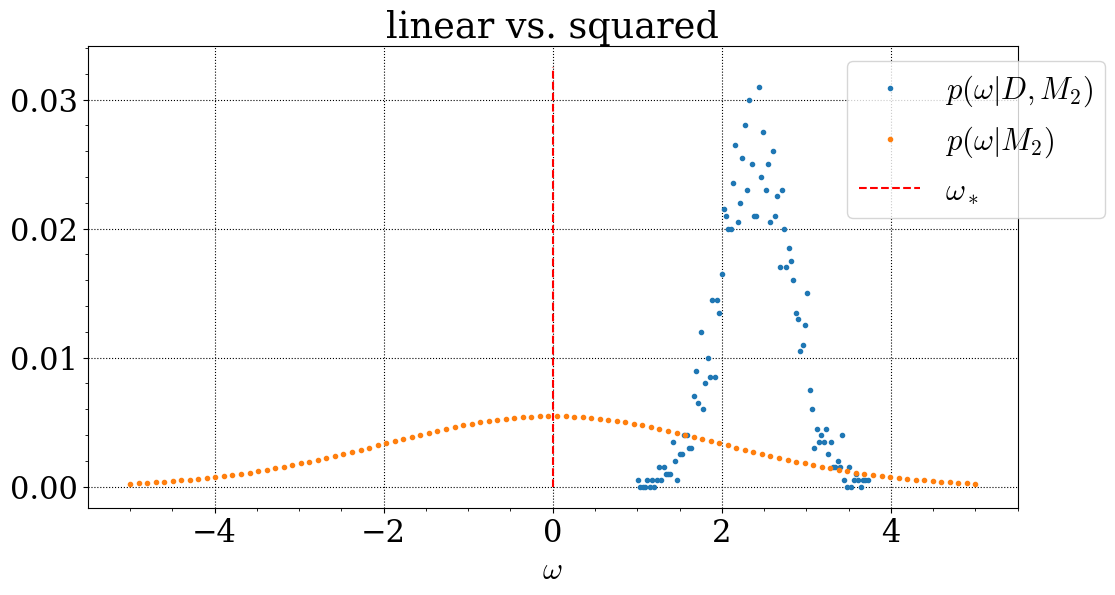

Integral:  1.0
SDDR: loooog 0.91340854216453


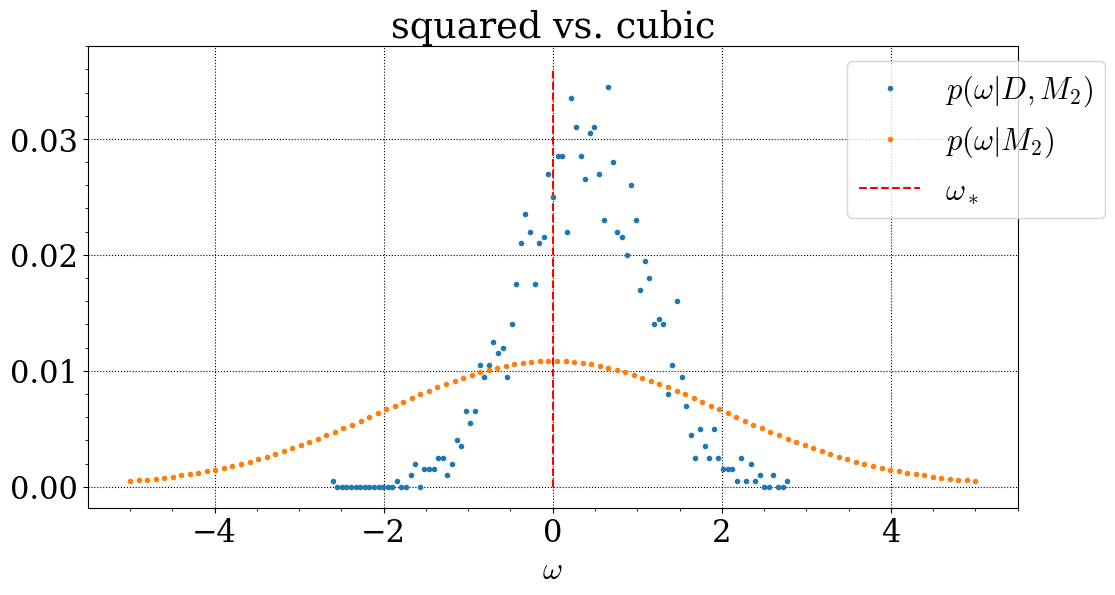

In [12]:
def find_y_for_x(x, y, value):
    i = 0
    while i != len(x):
        if x[i]<= value and x[i+1]>= value:
            return y[i]
            print("jippy")
            break
        if i == len(x)-1:
            return y[0]
            break 
        i+=1

def trace_extractor(trace, param_name,title):
    plt.figure(figsize=(12,6))
    bins = 100
    trace_param = trace[param_name]#extract parameter from trace
    hist_tmp = np.histogram(trace_param, bins=bins)#make histo
    hist = [hist_tmp[0]/np.sum(hist_tmp[0]), hist_tmp[1]] #normalize histo
    print("Integral: ",np.sum(hist[0]))#check normalization
    plt.plot(hist[1][:-1], hist[0],".", label = "$p(\omega|D,M_2)$")#plot
    #generate prior distribution
    sigma = prior_sigma
    mu = 0
    bin_per_x=(np.amax(hist[1])-np.amin(hist[1]))/bins # to compare histos with function multiply by this
    x_val = np.linspace(-5,5,100)
    y_val=norm(loc=0,scale=prior_sigma)
    y_val=y_val.pdf(x_val)*bin_per_x
    
    plt.plot(x_val, y_val,".", label = "$p(\omega|M_2)$")#scale the prior so it looks nicer
    plt.vlines(x=0, ymin=0, ymax=np.amax(hist[0])*1.05, color="r", ls="--", label = "$\omega_*$")
    y_found = find_y_for_x(hist[1][:-1], hist[0], 0)
    y_prior = find_y_for_x(x_val, y_val, 0)
    print("SDDR: loooog",np.log(y_found/y_prior))
    #plt.hlines(y=y_found, xmin=np.amin(hist[1][:-1])*10,xmax=np.amax(hist[1][:-1])*10, ls="--",color="black", label = "$p(\omega=\omega_*|D,M_2)$")
    #plt.hlines(y=y_prior, xmin=np.amin(hist[1][:-1])*10,xmax=np.amax(hist[1][:-1])*10, ls="-.",color="darkblue", label = "$p(\omega=\omega_*|M_2)$")
    beauty_settings()
    lgd=plt.legend(bbox_to_anchor=(0.8,1), ncol=1)
    plt.xlabel("$\omega$")
    plt.title(title)
    plt.savefig(savepath+"SDDR_"+title+nametag+"+.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    return np.log(y_found/y_prior)
y1 = []
y2 = []
for i in range(0,5):#several monte carlo runs to estimate an error
    with pm.Model() as lin_model:  # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
        a = pm.Normal("a", 0, sigma=prior_sigma)

        mu = pm.Deterministic('mu', intercept + a * x)
        # Define likelihood
        likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
        # Inference!
        lin_trace =  pm.sample_smc(sampleSize, parallel=False) 

    with pm.Model() as const_model:  # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
        # Define likelihood
        mu = pm.Deterministic('mu', intercept+x*0)
        likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

        # Inference!
        const_trace =  pm.sample_smc(sampleSize, parallel=False) 

    with pm.Model() as sq_model:  # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        #sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
        intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
        a = pm.Normal("a", 0, sigma=prior_sigma)
        b = pm.Normal("b", 0, sigma=prior_sigma)

        # Define likelihood
        mu = pm.Deterministic('mu', intercept+x*b+a*x**2)
        likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

        # Inference!
        sq_trace =  pm.sample_smc(sampleSize, parallel=False) 

    with pm.Model() as cub_model:
        #define priors
        intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
        a = pm.Normal("a", 0, sigma=prior_sigma)
        b = pm.Normal("b", 0, sigma=prior_sigma)
        c = pm.Normal("c", 0, sigma=prior_sigma)
        #define likelihood
        mu = pm.Deterministic('mu', intercept+c*x+b*x**2+a*x**3)
        likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
        # Inference!
        cub_trace =  pm.sample_smc(sampleSize, parallel=False)
        
    y1.append(trace_extractor(sq_trace,"a",'linear vs. squared'))
    y2.append(trace_extractor(cub_trace,"a",'squared vs. cubic'))


In [13]:
print("SDDR lin-sq: "+str(np.mean(y1))+" +- "+ str(np.std(y1)))
print("SDDR sq-cub: "+str(np.mean(y2))+" +- "+ str(np.std(y2)))

SDDR lin-sq: -2.1511704699422407 +- 0.35860914754824597
SDDR sq-cub: 0.8632654650314346 +- 0.0981186445607698


## Bayes Complexity
As a measure of model comparison, the bayesian complexity was introduced. We implement equation (8) of our report.

In [14]:
#for now lets assume we look at a polynomial of degree n and want to compute the bayesian complexity like Kunz et. al.

def poly_model(x,params): #params is array from highest order to lowest order of coefficents
    return np.polyval(params, x) # we look at polynomials of degree n where n is determined by the length of the params array

def logli(sigma,datapoints_x,datapoints_y,params): # we compute chi^2 but name it logli
    N=len(datapoints_x)
    loglikelihood=0
    for i in range(len(datapoints_x)):
        loglikelihood+=(datapoints_y[i]-poly_model(datapoints_x[i],params))**2/(sigma**2)#sum all chi^2 values for the datapoints (x,y)
    return loglikelihood

def bayes_complexity(datapoints_x,datapoints_y,sigma,params,trace):#params is a list of strings with parameter NAMES
    param_means=np.array([np.mean(trace[i])for i in params])#compute the mean of all sampled parameters
    param_samples=np.array([trace[i] for i in params])#extract sampled parameter values in array (with lists) param_samples, this has numberofparams*numberofsamples entries
    loglikelihood=logli(sigma,datapoints_x,datapoints_y,param_samples)#create an array loglikelihood (which is chi^2) each entry is determined by a sampled parameter-vector
    mean_loglikelihood=logli(sigma,datapoints_x,datapoints_y,param_means)#compute ONE value for chi^2 with the means of all parameters
    return (np.mean(loglikelihood)-mean_loglikelihood) #build mean of loglikelihood wrt to the samples and substract the loglikelihood computed from the mean parametervalues



In [15]:
#### Code without the python advantages ;) step by step, it yields the same results! note how the above solution is much more elegant and shorter
def poly_model(x,params): #params is array from highest order to lowest order of coefficents
    return np.polyval(params, x)#return polynom of ordern len(params)

def chi_sq(data_x,data_y,sigma,params): #this calculates chi^2 for ONE set of params for all data points
    chi = 0
    #print(params[0])
    for i in range(len(data_x)):
        chi+=(data_y[i]-(poly_model(data_x[i], params)))**2/(sigma**2) #plug in definition and profit
    return chi

def chi_sq_mean(data_x,data_y,sigma,trace,param_names): # this calculates the mean \bar{chi^2} wrt the posterior
    chi_sum = 0
    param_samples =np.array([trace[i] for i in param_names]) #params is array from highest order to lowest order of coefficents 
    #we now have an array with numberofparams * numberofsamples entries 
    #print(param_samples[0][0])
    for t in range(len(param_samples[0])):
        chi_sum += chi_sq(data_x,data_y,sigma, [param_samples[i][t] for i in range(len(param_names))])#pick out the parameter samples at place t from parameter i 
    chi_mean = chi_sum/(len(param_samples[0]))#build mean by normalizing
    return chi_mean

def mean_params_chi(data_x,data_y,sigma,trace,param_names):#this calculates the chi^2 value for theta_hat, in our case the mean of each sampled value, see posterior dist. above
    param_means=np.array([np.mean(trace[i])for i in param_names])#use np.mean() to calculate mean
    return chi_sq(data_x,data_y,sigma, param_means)#return chi^2(theta_hat)

def bayes_complexity_c(data_x,data_y,sigma,trace, param_names):
    return chi_sq_mean(data_x,data_y,sigma,trace, param_names)-mean_params_chi(data_x,data_y,sigma,trace,param_names)#this is the complexity which we want to calculate all along


## Results of Complexity
After implementing it we have to visualize our findings.

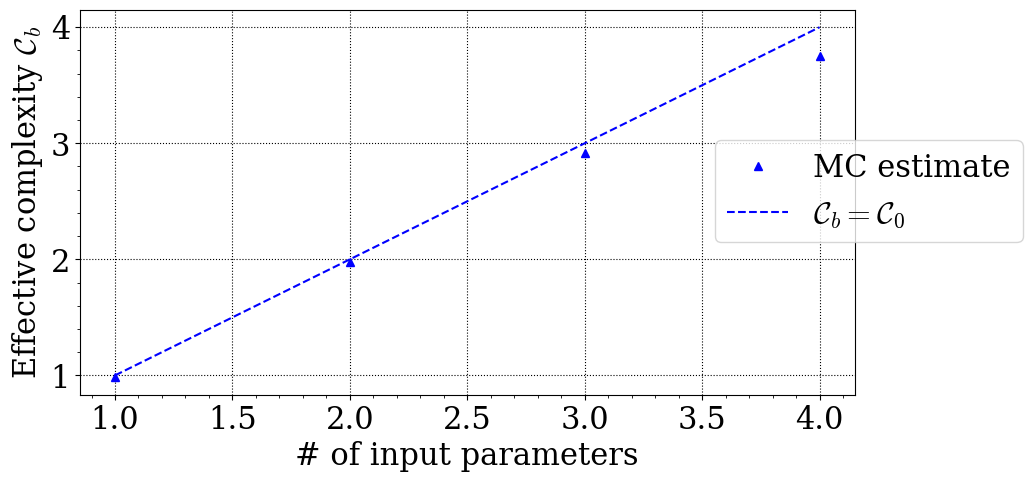

In [16]:
beauty_plot()
const_params=['Intercept']
cub_params=['a','b','c','Intercept']
sq_params=['a','b','Intercept']
lin_params=['a','Intercept']

traces=[const_trace,lin_trace,sq_trace,cub_trace]
param_list_list=[const_params,lin_params,sq_params,cub_params]
complexity_list=[]
for i in range(0,4):
    complexity_list.append(bayes_complexity(x,y,sigma,param_list_list[i],traces[i]))

xx=[1,2,3,4]
yy=xx
plt.plot(xx,complexity_list,'b^', label="MC estimate")
plt.plot(xx,yy,'b--',label="$\mathcal{C}_b=\mathcal{C}_0$")
plt.xlabel('# of input parameters')
plt.ylabel('Effective complexity $\mathcal{C}_b$')
lgd=plt.legend(bbox_to_anchor=(.8,.7), ncol=1)
plt.savefig(savepath+nametag+"complexity.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Pictures
Here a some plots we used in the report

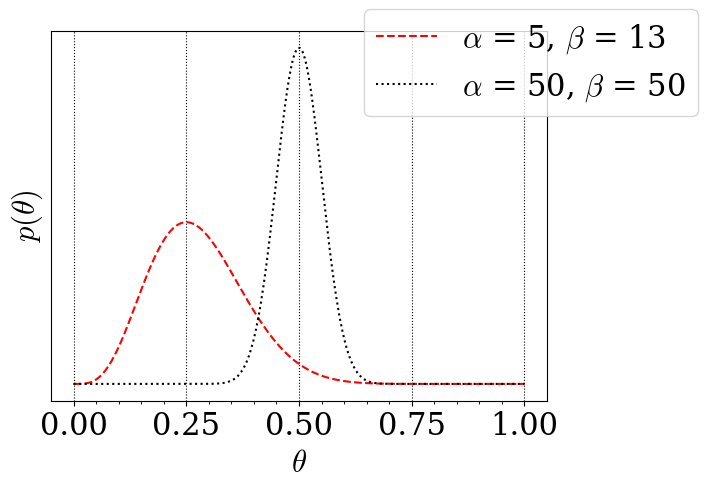

In [17]:
a=5
priors = ((a, 3*a-2), (50, 50))
color=["red","black"]
lstyle=["--",":"]
beauty_settings()
i=0
for a, b in priors:
    distri = beta(a, b)
    x = np.linspace(0, 1, 300)
    x_pdf = distri.pdf(x)
    plt.plot(x, x_pdf, label=fr"$\alpha$ = {a:d}, $\beta$ = {b:d}",color=color[i], ls=lstyle[i])
    plt.yticks([])
    plt.xlabel("$\\theta$")
    plt.ylabel("$p(\\theta)$")
    lgd=plt.legend(bbox_to_anchor=(0.6,+1.1))
    i+=1
plt.savefig(savepath+"beta_dist.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [18]:
def beta_binom(prior, y):
    """
    Compute the marginal likelihood, analytically, for a beta-binomial model.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    alpha, beta = prior
    h = np.sum(y)
    n = len(y)
    p_y = np.exp(betaln(alpha + h, beta + n - h) - betaln(alpha, beta))
    return p_y
y = heads[:50]
BF = beta_binom(priors[0], y) / beta_binom(priors[1], y)
print(BF)

9.583868650799053
